<h1>Statistical Approach for AML Threshold Tuning with Python</h1>

Tutorial at Medium: https://medium.com/@jasonclwu/statistical-approach-for-aml-threshold-tuning-with-python-51baf21203a?source=friends_link&sk=c27437bb1ed24ee44984afa1a7bcb735

Notebook at Github: https://github.com/jasonclwu/202208_AML_Threshold_Tuning


<h2>Importing Libraries</h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.float_format = '{:,.4f}'.format

<h2>Unzip Dataset</h2>

In [2]:
## https://www.kaggle.com/datasets/anshankul/ibm-amlsim-example-dataset

# from zipfile import ZipFile
# with ZipFile('data.zip','r') as zip:
#     zip.extractall(path='data')

<h2>Reading account.csv and transactions.csv</h2>

In [3]:
acct_raw = pd.read_csv('data/accounts.csv', usecols=['ACCOUNT_ID','IS_FRAUD'])
acct_raw.rename(columns={'IS_FRAUD':'SUSPICIOUS'}, inplace=True)
acct_raw['SUSPICIOUS'] = acct_raw['SUSPICIOUS'].astype(int)
acct_raw

,ACCOUNT_ID,SUSPICIOUS
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
9995,9995,1
9996,9996,1
9997,9997,1
9998,9998,1


In [4]:
txn_raw = pd.read_csv('data/transactions.csv', usecols=['SENDER_ACCOUNT_ID','RECEIVER_ACCOUNT_ID','TX_AMOUNT'])
txn_raw

,SENDER_ACCOUNT_ID,RECEIVER_ACCOUNT_ID,TX_AMOUNT
0,6456,9069,465.0500
1,7516,9543,564.6400
2,2445,9356,598.9400
3,2576,4617,466.0700
4,3524,1773,405.6300
...,...,...,...
1323229,3733,8051,112.9800
1323230,2536,8732,459.6400
1323231,1466,8586,468.6000
1323232,1451,3849,562.3600


<h2>Create transaction summary for customers</h2>

In [5]:
credit_summary = txn_raw.groupby('RECEIVER_ACCOUNT_ID', as_index=False).agg({'TX_AMOUNT':['sum','count'], 'SENDER_ACCOUNT_ID':'nunique'})
credit_summary.columns=['ACCOUNT_ID','CREDIT_AMT','CREDIT_COUNT','CREDIT_CTPY']
credit_summary

,ACCOUNT_ID,CREDIT_AMT,CREDIT_COUNT,CREDIT_CTPY
0,3,313.4900,23,1
1,5,156.7500,19,1
2,6,"3,823.8000",20,1
3,7,"2,816.6000",20,1
4,9,"9,479,685.4400",3,1
...,...,...,...,...
9921,9995,"281,962,041.0400",1679,114
9922,9996,"489,410,718.2500",1751,135
9923,9997,"358,446,925.7000",1850,140
9924,9998,"434,224,149.2000",2767,164


In [6]:
debit_summary = txn_raw.groupby('SENDER_ACCOUNT_ID', as_index=False).agg({'TX_AMOUNT':['sum','count'], 'RECEIVER_ACCOUNT_ID':'nunique'})
debit_summary.columns=['ACCOUNT_ID','DEBIT_AMT','DEBIT_COUNT','DEBIT_CTPY']
debit_summary

,ACCOUNT_ID,DEBIT_AMT,DEBIT_COUNT,DEBIT_CTPY
0,1,"4,219.2000",24,1
1,2,"2,556.9000",18,1
2,3,"2,391.7200",19,1
3,4,"3,475.9900",23,1
4,5,"2,669.1200",38,2
...,...,...,...,...
9994,9995,"82,422.5300",210,12
9995,9996,"103,533.3600",303,15
9996,9997,"46,963.7200",183,13
9997,9998,"111,730.1200",348,18


In [7]:
acct = acct_raw.merge(credit_summary, on='ACCOUNT_ID', how='left').merge(debit_summary, on='ACCOUNT_ID', how='left').fillna(0).drop(columns=['ACCOUNT_ID'])
acct

,SUSPICIOUS,CREDIT_AMT,CREDIT_COUNT,CREDIT_CTPY,DEBIT_AMT,DEBIT_COUNT,DEBIT_CTPY
0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0,0.0000,0.0000,0.0000,"4,219.2000",24.0000,1.0000
2,0,0.0000,0.0000,0.0000,"2,556.9000",18.0000,1.0000
3,0,313.4900,23.0000,1.0000,"2,391.7200",19.0000,1.0000
4,0,0.0000,0.0000,0.0000,"3,475.9900",23.0000,1.0000
...,...,...,...,...,...,...,...
9995,1,"281,962,041.0400","1,679.0000",114.0000,"82,422.5300",210.0000,12.0000
9996,1,"489,410,718.2500","1,751.0000",135.0000,"103,533.3600",303.0000,15.0000
9997,1,"358,446,925.7000","1,850.0000",140.0000,"46,963.7200",183.0000,13.0000
9998,1,"434,224,149.2000","2,767.0000",164.0000,"111,730.1200",348.0000,18.0000


<h2>Manual Threshold Simulation</h2>

In [8]:
for threshold in [100000, 500000, 1000000]:
    no_of_alert = (acct['CREDIT_AMT']>=threshold).sum()
    print(f'Threshold: {threshold} | No. of Alert: {no_of_alert}')

Threshold: 100000 | No. of Alert: 7766
Threshold: 500000 | No. of Alert: 7109
Threshold: 1000000 | No. of Alert: 6736


In [9]:
min_threshold = acct['CREDIT_AMT'].min()
max_threshold = acct['CREDIT_AMT'].max()

print(f'Minimum threshold = {min_threshold:,.0f}')
print(f'Maximum threshold = {max_threshold:,.0f}')

Minimum threshold = 0
Maximum threshold = 489,410,718


<h2>Train-Test Split</h2>

In [10]:
acct['SUSPICIOUS'].value_counts()

0    8315
1    1685
Name: SUSPICIOUS, dtype: int64

In [11]:
acct_train = pd.concat([
    acct[acct['SUSPICIOUS']==0].sample(frac=0.6, random_state=721),
    acct[acct['SUSPICIOUS']==1].sample(frac=0.6, random_state=721)]).sort_index()
    
acct_test = acct[~acct.index.isin(acct_train.index)]

In [12]:
print('Train Set\n', acct_train['SUSPICIOUS'].value_counts(), '\n')
print('Test Set\n', acct_test['SUSPICIOUS'].value_counts())

Train Set
 0    4989
1    1011
Name: SUSPICIOUS, dtype: int64 

Test Set
 0    3326
1     674
Name: SUSPICIOUS, dtype: int64


In [13]:
acct_train

,SUSPICIOUS,CREDIT_AMT,CREDIT_COUNT,CREDIT_CTPY,DEBIT_AMT,DEBIT_COUNT,DEBIT_CTPY
0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0,0.0000,0.0000,0.0000,"4,219.2000",24.0000,1.0000
3,0,313.4900,23.0000,1.0000,"2,391.7200",19.0000,1.0000
4,0,0.0000,0.0000,0.0000,"3,475.9900",23.0000,1.0000
5,0,156.7500,19.0000,1.0000,"2,669.1200",38.0000,2.0000
...,...,...,...,...,...,...,...
9980,1,"120,164,716.9300","2,545.0000",110.0000,"40,142.8800",129.0000,10.0000
9985,1,"227,980,452.6500","1,560.0000",91.0000,"48,585.1300",146.0000,8.0000
9987,1,"203,889,349.0900","1,271.0000",96.0000,"28,314.7700",122.0000,10.0000
9997,1,"358,446,925.7000","1,850.0000",140.0000,"46,963.7200",183.0000,13.0000


In [14]:
acct_test

,SUSPICIOUS,CREDIT_AMT,CREDIT_COUNT,CREDIT_CTPY,DEBIT_AMT,DEBIT_COUNT,DEBIT_CTPY
2,0,0.0000,0.0000,0.0000,"2,556.9000",18.0000,1.0000
7,0,"2,816.6000",20.0000,1.0000,"2,215.4400",34.0000,2.0000
8,0,0.0000,0.0000,0.0000,"3,396.1800",46.0000,2.0000
9,0,"9,479,685.4400",3.0000,1.0000,"2,849.7600",36.0000,2.0000
10,0,"2,076.0000",20.0000,1.0000,"4,006.8000",42.0000,2.0000
...,...,...,...,...,...,...,...
9993,1,"281,534,474.5600","3,948.0000",161.0000,"47,225.8800",210.0000,12.0000
9994,1,"187,711,650.3000","2,730.0000",136.0000,"78,793.1300",211.0000,13.0000
9995,1,"281,962,041.0400","1,679.0000",114.0000,"82,422.5300",210.0000,12.0000
9996,1,"489,410,718.2500","1,751.0000",135.0000,"103,533.3600",303.0000,15.0000


<h2>Statistical Distribution Analysis</h2>

In [15]:
acct_train.describe()

,SUSPICIOUS,CREDIT_AMT,CREDIT_COUNT,CREDIT_CTPY,DEBIT_AMT,DEBIT_COUNT,DEBIT_CTPY
count,"6,000.0000","6,000.0000","6,000.0000","6,000.0000","6,000.0000","6,000.0000","6,000.0000"
mean,0.1685,"14,690,790.3536",127.9237,6.6293,"15,114,004.1528",132.7167,6.8730
std,0.3743,"21,807,496.3685",177.4488,7.2067,"35,188,939.8861",131.4640,6.8994
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,"194,994.2850",45.0000,3.0000,"4,945.7175",22.0000,1.0000
50%,0.0000,"6,418,400.1450",78.0000,5.0000,"28,632.8000",133.0000,6.0000
75%,0.0000,"22,438,217.8700",127.0000,7.0000,"99,931.0125",180.0000,10.0000
max,1.0000,"434,224,149.2000","3,420.0000",164.0000,"235,780,317.5000",963.0000,48.0000


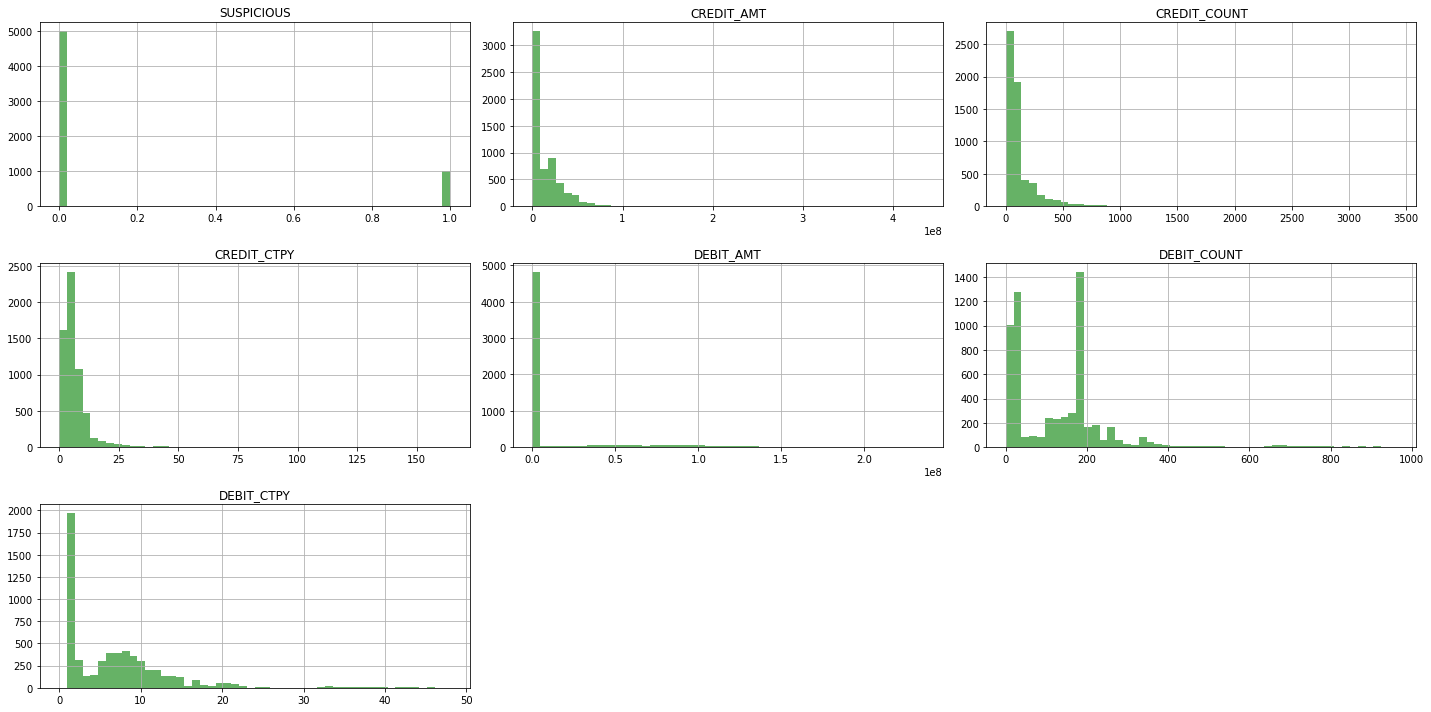

In [16]:
acct_train.hist(bins=50, figsize=(20,10), color='green', alpha=0.6)
plt.tight_layout()
plt.show()

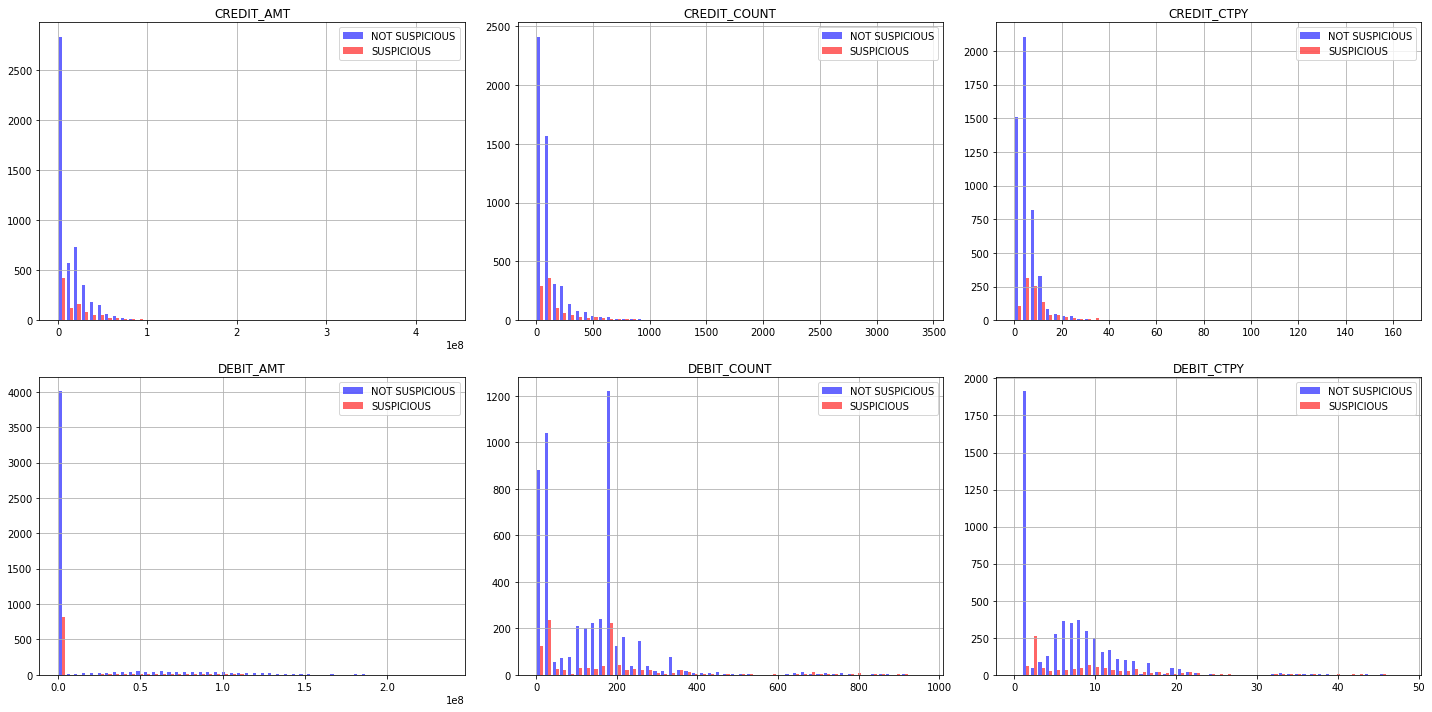

In [17]:
fig, ax = plt.subplots(2,3, figsize=(20,10))

for index, feature in enumerate(acct_train.columns[1:4]):

    data1 = acct_train[acct_train['SUSPICIOUS']==0][feature]
    data2 = acct_train[acct_train['SUSPICIOUS']==1][feature]

    ax[0][index].hist([data1, data2], bins=50, color=['blue','red'], alpha=0.6)
    ax[0][index].legend(labels=['NOT SUSPICIOUS','SUSPICIOUS'])
    ax[0][index].set_title(feature)
    ax[0][index].grid()

for index, feature in enumerate(acct_train.columns[4:]):

    data1 = acct_train[acct_train['SUSPICIOUS']==0][feature]
    data2 = acct_train[acct_train['SUSPICIOUS']==1][feature]

    ax[1][index].hist([data1, data2], bins=50, color=['blue','red'], alpha=0.6)
    ax[1][index].legend(labels=['NOT SUSPICIOUS','SUSPICIOUS'])
    ax[1][index].set_title(feature)
    ax[1][index].grid()

plt.tight_layout()
plt.show()

In [18]:
skewness = pd.concat([
    acct_train.skew(),
    acct_train[acct_train['SUSPICIOUS']==0].skew(),
    acct_train[acct_train['SUSPICIOUS']==1].skew()],axis=1)

skewness.columns=['ALL','NOT SUSPICIOUS','SUSPICIOUS']

skewness

,ALL,NOT SUSPICIOUS,SUSPICIOUS
SUSPICIOUS,1.7717,0.0000,0.0000
CREDIT_AMT,4.5940,2.7252,4.3018
CREDIT_COUNT,5.8886,3.6287,4.9637
CREDIT_CTPY,7.2963,4.0601,4.9598
DEBIT_AMT,2.4505,2.4608,2.3866
DEBIT_COUNT,2.3225,2.1744,2.0658
DEBIT_CTPY,2.1042,2.0345,1.7394


<h2>Fallacy of Using the Mean+3SD as Threshold</h2>

Some may suggest using the mean + 3 standard deviations as the threshold. This practice is originated from empirical rule which suggests that the top 0.135% of customers will be captured at that threshold.

https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule

There are 2 fallacies here:
- Capturing top 0.135% of customers does not represent maximization of effectiveness.
- The feature distribution is not likely in normal distribution which you will get a different coverage with the threshold.


In [19]:
sample_size_df = pd.DataFrame()

for feature in acct_train.columns[1:]:
    mean = acct_train[feature].describe()['mean']
    std = acct_train[feature].describe()['std']
    sample_size = {}

    for distance in range (0,6):
        sample_size['feature'] = feature
        sample_size[f'+{distance} std'] = len(acct_train[acct_train[feature]>=mean+distance*std]) / len(acct_train)
    
    sample_size_df = sample_size_df.append(pd.DataFrame(sample_size, index=[0]), ignore_index=True)

In [20]:
sample_size_df

,feature,+0 std,+1 std,+2 std,+3 std,+4 std,+5 std
0,CREDIT_AMT,0.3715,0.1107,0.0332,0.0143,0.0077,0.0050
1,CREDIT_COUNT,0.2492,0.0850,0.0378,0.0177,0.0103,0.0058
2,CREDIT_CTPY,0.3275,0.0703,0.0282,0.0153,0.0095,0.0062
3,DEBIT_AMT,0.1897,0.1385,0.0775,0.0278,0.0062,0.0008
4,DEBIT_COUNT,0.5023,0.0787,0.0320,0.0215,0.0180,0.0057
5,DEBIT_CTPY,0.4563,0.1213,0.0415,0.0197,0.0135,0.0043


<h2>Threshold Simulation</h2>

In [21]:
min_threshold = acct_train['CREDIT_AMT'].min()
max_threshold = acct_train['CREDIT_AMT'].max()

print(f'Minimum threshold = {min_threshold:,.0f}')
print(f'Maximum threshold = {max_threshold:,.0f}')

Minimum threshold = 0
Maximum threshold = 434,224,149


<h3>Threshold Simulation at 75th Percentile</h3>

In [22]:
target_feature = 'CREDIT_AMT'
q = 0.75
threshold = acct_train[target_feature].quantile(q=q)

summary_train = {}
summary_train['feature'] = target_feature
summary_train['percentile'] = q
summary_train['threshold'] = threshold
summary_train['no_of_alerts'] = (acct_train[target_feature]>=threshold).sum()
summary_train['tp_count'] = ((acct_train[target_feature]>=threshold) & (acct_train['SUSPICIOUS']==1)).sum()
summary_train['fp_count'] = ((acct_train[target_feature]>=threshold) & (acct_train['SUSPICIOUS']==0)).sum()
summary_train['tn_count'] = ((acct_train[target_feature]<threshold) & (acct_train['SUSPICIOUS']==0)).sum()
summary_train['fn_count'] = ((acct_train[target_feature]<threshold) & (acct_train['SUSPICIOUS']==1)).sum()

pd.DataFrame(summary_train, index=[0])

,feature,percentile,threshold,no_of_alerts,tp_count,fp_count,tn_count,fn_count
0,CREDIT_AMT,0.7500,"22,438,217.8700",1500,362,1138,3851,649


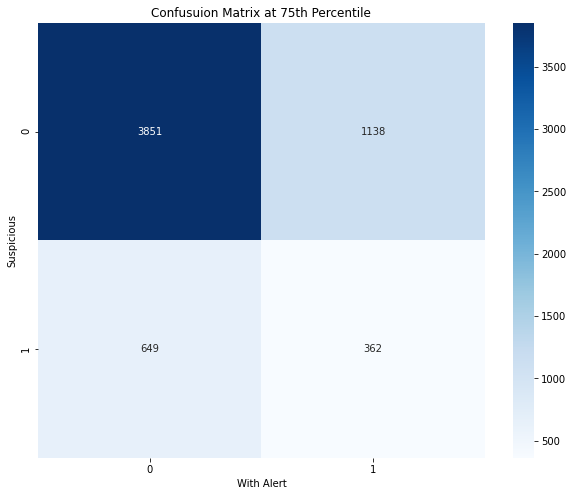

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_suspicious = acct_train['SUSPICIOUS']
y_alert = (acct_train[target_feature]>=threshold).astype(int)

plt.figure(figsize = (10,8))
sns.heatmap(confusion_matrix(y_suspicious, y_alert), annot=True, cmap='Blues', fmt='g')
plt.xlabel('With Alert')
plt.ylabel('Suspicious')
plt.title('Confusuion Matrix at 75th Percentile')
plt.show()

<h3>Threshold Simulation for all Percentile</h3>

In [24]:
target_feature = 'CREDIT_AMT'

summary_train_df = pd.DataFrame()

for i in range(1, 100):
    
    q = i/100
    threshold = acct_train[target_feature].quantile(q=q)

    summary_train = {}
    summary_train['feature'] = target_feature
    summary_train['percentile'] = q
    summary_train['threshold'] = threshold
    summary_train['no_of_alerts'] = (acct_train[target_feature]>=threshold).sum()
    summary_train['tp_count'] = ((acct_train[target_feature]>=threshold) & (acct_train['SUSPICIOUS']==1)).sum()
    summary_train['fp_count'] = ((acct_train[target_feature]>=threshold) & (acct_train['SUSPICIOUS']==0)).sum()
    summary_train['tn_count'] = ((acct_train[target_feature]<threshold) & (acct_train['SUSPICIOUS']==0)).sum()
    summary_train['fn_count'] = ((acct_train[target_feature]<threshold) & (acct_train['SUSPICIOUS']==1)).sum()

    summary_train_df = summary_train_df.append(pd.DataFrame(summary_train, index=[0]), ignore_index=True)

In [25]:
summary_train_df

,feature,percentile,threshold,no_of_alerts,tp_count,fp_count,tn_count,fn_count
0,CREDIT_AMT,0.0100,220.3087,5940,1006,4934,55,5
1,CREDIT_AMT,0.0200,609.8504,5880,1002,4878,111,9
2,CREDIT_AMT,0.0300,"2,231.5106",5820,996,4824,165,15
3,CREDIT_AMT,0.0400,"2,773.9840",5760,992,4768,221,19
4,CREDIT_AMT,0.0500,"3,251.6480",5700,988,4712,277,23
...,...,...,...,...,...,...,...,...
94,CREDIT_AMT,0.9500,"49,781,318.6680",300,122,178,4811,889
95,CREDIT_AMT,0.9600,"54,243,412.3024",240,102,138,4851,909
96,CREDIT_AMT,0.9700,"60,957,992.0356",180,86,94,4895,925
97,CREDIT_AMT,0.9800,"69,326,914.5590",120,63,57,4932,948


<h3>Finding Threshold With Best J Statistic</h3>

In [26]:
summary_train_df['tp_rate'] = summary_train_df['tp_count'] / (summary_train_df['tp_count'] + summary_train_df['fn_count'])
summary_train_df['fp_rate'] = summary_train_df['fp_count'] / (summary_train_df['fp_count'] + summary_train_df['tn_count'])
summary_train_df['j_stat'] = summary_train_df['tp_rate'] - summary_train_df['fp_rate']
best_j_stat_df = summary_train_df[summary_train_df['j_stat'] == summary_train_df['j_stat'].max()]
best_j_stat_df

,feature,percentile,threshold,no_of_alerts,tp_count,fp_count,tn_count,fn_count,tp_rate,fp_rate,j_stat
63,CREDIT_AMT,0.6400,"15,661,391.0656",2160,499,1661,3328,512,0.4936,0.3329,0.1606


In [27]:
best_percentile_by_j_stat = best_j_stat_df.iloc[0]['percentile']
best_threshold_by_j_stat = best_j_stat_df.iloc[0]['threshold']
best_j_stat = best_j_stat_df.iloc[0]['j_stat']
best_fpr_by_j_stat = best_j_stat_df.iloc[0]['fp_rate']
best_tpr_by_j_stat = best_j_stat_df.iloc[0]['tp_rate']

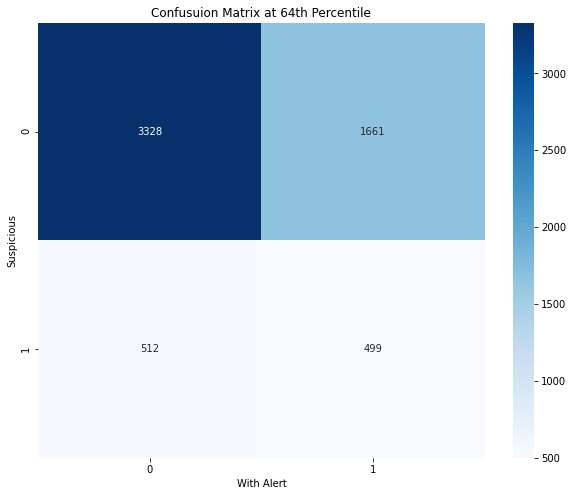

In [28]:
y_suspicious = acct_train['SUSPICIOUS']
y_alert = (acct_train[target_feature]>=best_threshold_by_j_stat).astype(int)

plt.figure(figsize = (10,8))
sns.heatmap(confusion_matrix(y_suspicious, y_alert), annot=True, cmap='Blues', fmt='g')
plt.xlabel('With Alert')
plt.ylabel('Suspicious')
plt.title(f'Confusuion Matrix at {best_percentile_by_j_stat*100:.0f}th Percentile')
plt.show()

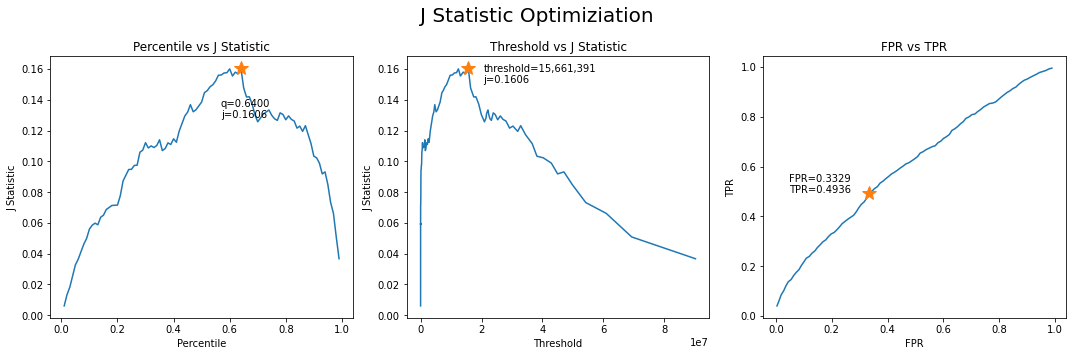

In [29]:
fig, ax = plt.subplots(1, 3 ,figsize=(15,5))
fig.suptitle('J Statistic Optimiziation', fontsize=20)

ax[0].set_title('Percentile vs J Statistic')
ax[0].set_xlabel('Percentile')
ax[0].set_ylabel('J Statistic')
ax[0].plot(summary_train_df['percentile'], summary_train_df['j_stat'])
ax[0].plot(best_percentile_by_j_stat, best_j_stat, marker='*', ls='none', ms=15)
ax[0].annotate(f'q={best_percentile_by_j_stat:.4f}\nj={best_j_stat:.4f}', (best_percentile_by_j_stat, best_j_stat), xytext=(-20,-50), textcoords='offset points')

ax[1].set_title('Threshold vs J Statistic')
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('J Statistic')
ax[1].plot(summary_train_df['threshold'], summary_train_df['j_stat'])
ax[1].plot(best_threshold_by_j_stat, best_j_stat, marker='*', ls='none', ms=15)
ax[1].annotate(f'threshold={best_threshold_by_j_stat:,.0f}\nj={best_j_stat:.4f}', (best_threshold_by_j_stat, best_j_stat), xytext=(15,-15), textcoords='offset points')

ax[2].set_title('FPR vs TPR')
ax[2].set_xlabel('FPR')
ax[2].set_ylabel('TPR')
ax[2].plot(summary_train_df['fp_rate'], summary_train_df['tp_rate'])
ax[2].plot(best_fpr_by_j_stat, best_tpr_by_j_stat, marker='*', ls='none', ms=15)
ax[2].annotate(f'FPR={best_fpr_by_j_stat:.4f}\nTPR={best_tpr_by_j_stat:.4f}', (best_fpr_by_j_stat, best_tpr_by_j_stat), xytext=(-80,0), textcoords='offset points')

plt.tight_layout()
plt.show()

<h3>Finding Threshold With Best F1 Score</h3>

In [30]:
summary_train_df['precision'] = summary_train_df['tp_count'] / (summary_train_df['tp_count'] + summary_train_df['fp_count'])
summary_train_df['recall'] = summary_train_df['tp_rate']
summary_train_df['f1'] = (2 * summary_train_df['precision'] * summary_train_df['recall']) / (summary_train_df['precision'] + summary_train_df['recall'])
best_f1_df = summary_train_df[summary_train_df['f1'] == summary_train_df['f1'].max()]
best_f1_df.drop(columns=['tp_rate','fp_rate','j_stat'])

,feature,percentile,threshold,no_of_alerts,tp_count,fp_count,tn_count,fn_count,precision,recall,f1
59,CREDIT_AMT,0.6000,"12,412,188.7940",2400,539,1861,3128,472,0.2246,0.5331,0.3160


In [31]:
best_percentile_by_f1 = best_f1_df.iloc[0]['percentile']
best_threshold_by_f1 = best_f1_df.iloc[0]['threshold']
best_f1 = best_f1_df.iloc[0]['f1']
best_precision_by_f1 = best_f1_df.iloc[0]['precision']
best_recall_by_f1 = best_f1_df.iloc[0]['recall']

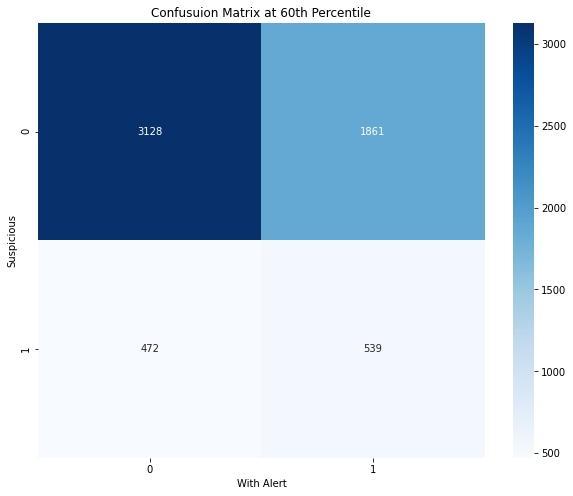

In [32]:
y_suspicious = acct_train['SUSPICIOUS']
y_alert = (acct_train[target_feature]>=best_threshold_by_f1).astype(int)

plt.figure(figsize = (10,8))
sns.heatmap(confusion_matrix(y_suspicious, y_alert), annot=True, cmap='Blues', fmt='g')
plt.xlabel('With Alert')
plt.ylabel('Suspicious')
plt.title(f'Confusuion Matrix at {best_percentile_by_f1*100:.0f}th Percentile')
plt.show()

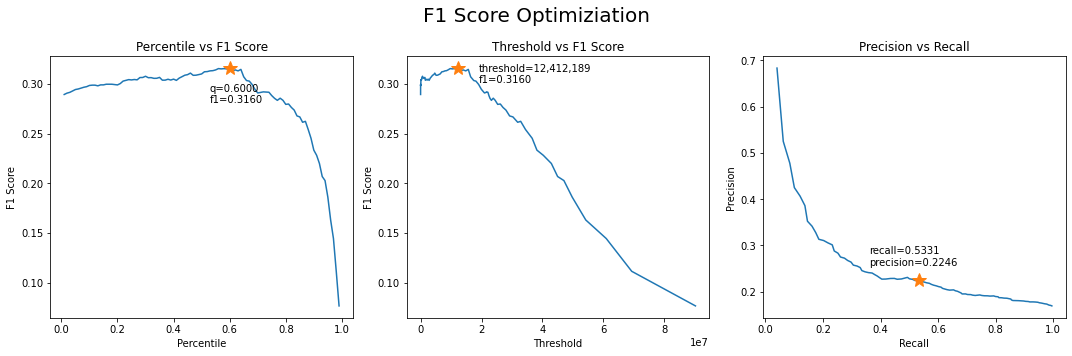

In [33]:
fig, ax = plt.subplots(1, 3 ,figsize=(15,5))
fig.suptitle('F1 Score Optimiziation', fontsize=20)

ax[0].set_title('Percentile vs F1 Score')
ax[0].set_xlabel('Percentile')
ax[0].set_ylabel('F1 Score')
ax[0].plot(summary_train_df['percentile'], summary_train_df['f1'])
ax[0].plot(best_percentile_by_f1, best_f1, marker='*', ls='none', ms=15)
ax[0].annotate(f'q={best_percentile_by_f1:.4f}\nf1={best_f1:.4f}', (best_percentile_by_f1,best_f1), xytext=(-20,-35), textcoords='offset points')

ax[1].set_title('Threshold vs F1 Score')
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('F1 Score')
ax[1].plot(summary_train_df['threshold'], summary_train_df['f1'])
ax[1].plot(best_threshold_by_f1, best_f1, marker='*', ls='none', ms=15)
ax[1].annotate(f'threshold={best_threshold_by_f1:,.0f}\nf1={best_f1:.4f}', (best_threshold_by_f1,best_f1), xytext=(20,-15), textcoords='offset points')

ax[2].set_title('Precision vs Recall')
ax[2].set_xlabel('Recall')
ax[2].set_ylabel('Precision')
ax[2].plot(summary_train_df['recall'], summary_train_df['precision'])
ax[2].plot(best_recall_by_f1, best_precision_by_f1, marker='*', ls='none', ms=15)
ax[2].annotate(f'recall={best_recall_by_f1:.4f}\nprecision={best_precision_by_f1:.4f}', (best_recall_by_f1, best_precision_by_f1), xytext=(-50,15), textcoords='offset points')

plt.tight_layout()
plt.show()

<h2>Compare J Statistic and F1 Score Recommendation</h2>

In [34]:
columns = ['percentile','threshold','no_of_alerts','tp_count','fp_count','tn_count','fn_count']
j_stat_vs_f1 = pd.concat([best_j_stat_df[columns].T,best_f1_df[columns].T], axis=1)
j_stat_vs_f1.columns = ['J Statistic','F1 Score']
j_stat_vs_f1.index.names=[target_feature]
j_stat_vs_f1

,J Statistic,F1 Score
CREDIT_AMT,,
percentile,0.6400,0.6000
threshold,"15,661,391.0656","12,412,188.7940"
no_of_alerts,"2,160.0000","2,400.0000"
tp_count,499.0000,539.0000
fp_count,"1,661.0000","1,861.0000"
tn_count,"3,328.0000","3,128.0000"
fn_count,512.0000,472.0000


- Recommendation from F1 Score is adopted to minimize number of false negative. Cut-off threshold = $12,412,188.7940

<h2>Validate Threshold Setting With Test Set</h2>

In [35]:
best_evaluation = best_f1_df
threshold = best_threshold_by_f1

summary_test = {}

summary_test['feature'] = target_feature
summary_test['threshold'] = threshold
summary_test['no_of_alerts'] = (acct_test[target_feature]>=threshold).sum()
summary_test['tp_count'] = ((acct_test[target_feature]>=threshold) & (acct_test['SUSPICIOUS']==1)).sum()
summary_test['fp_count'] = ((acct_test[target_feature]>=threshold) & (acct_test['SUSPICIOUS']==0)).sum()
summary_test['tn_count'] = ((acct_test[target_feature]<threshold) & (acct_test['SUSPICIOUS']==0)).sum()
summary_test['fn_count'] = ((acct_test[target_feature]<threshold) & (acct_test['SUSPICIOUS']==1)).sum()

summary_test_df = pd.DataFrame(summary_test, index=[0])

summary_test_df['tp_rate'] = summary_test_df['tp_count'] / (summary_test_df['tp_count'] + summary_test_df['fn_count'])
summary_test_df['fp_rate'] = summary_test_df['fp_count'] / (summary_test_df['fp_count'] + summary_test_df['tn_count'])
summary_test_df['j_stat'] = summary_test_df['tp_rate'] - summary_test_df['fp_rate']

summary_test_df['precision'] = summary_test_df['tp_count'] / (summary_test_df['tp_count'] + summary_test_df['fp_count'])
summary_test_df['recall'] = summary_test_df['tp_rate']
summary_test_df['f1'] = (2 * summary_test_df['precision'] * summary_test_df['recall']) / (summary_test_df['precision'] + summary_test_df['recall'])

comparison = pd.concat([
    best_evaluation.drop(columns=['feature','percentile']).head(1).T,
    summary_test_df.drop(columns=['feature']).T], axis=1)    
comparison.columns=['train','test']
comparison.index.names = [target_feature]
comparison['pct_change'] = (comparison['test'] - comparison['train']) / comparison['train']

comparison

,train,test,pct_change
CREDIT_AMT,,,
threshold,"12,412,188.7940","12,412,188.7940",0.0000
no_of_alerts,"2,400.0000","1,650.0000",-0.3125
tp_count,539.0000,393.0000,-0.2709
fp_count,"1,861.0000","1,257.0000",-0.3246
tn_count,"3,128.0000","2,069.0000",-0.3386
fn_count,472.0000,281.0000,-0.4047
tp_rate,0.5331,0.5831,0.0937
fp_rate,0.3730,0.3779,0.0132
j_stat,0.1601,0.2052,0.2813


<h2>Bonus: Evaluate Scenario Effectiveness</h2>

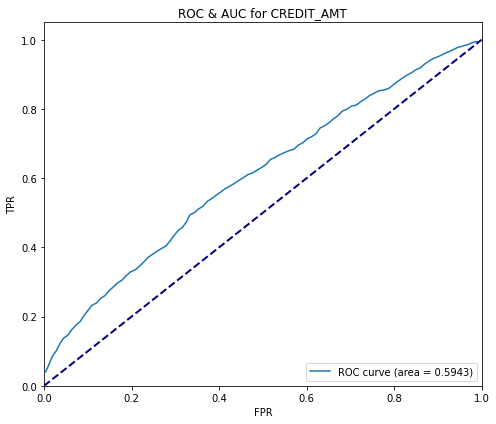

In [36]:
import numpy as np
auc = -np.trapz(summary_train_df['tp_rate'], summary_train_df['fp_rate'])

plt.figure(figsize=(7,6))
plt.plot(summary_train_df['fp_rate'], summary_train_df['tp_rate'], label=f'ROC curve (area = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC & AUC for {target_feature}')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

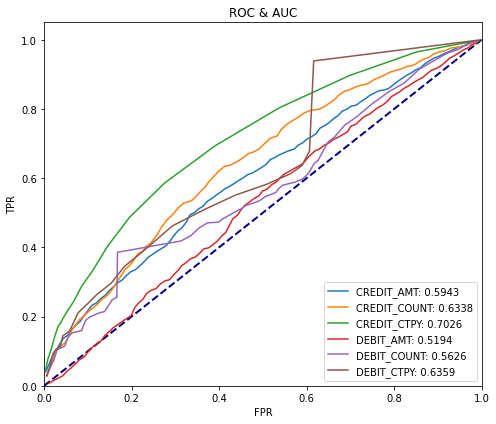

In [37]:
plt.figure(figsize=(7,6))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC & AUC')
plt.tight_layout()


for target_feature in acct_train.columns[1:]:
    summary_roc_df = pd.DataFrame()

    for i in range(1, 100):        
        threshold = acct_train[target_feature].quantile(q=i/100)
        summary_roc = {}
        summary_roc['tp_count'] = ((acct_train[target_feature]>=threshold) & (acct_train['SUSPICIOUS']==1)).sum()
        summary_roc['fp_count'] = ((acct_train[target_feature]>=threshold) & (acct_train['SUSPICIOUS']==0)).sum()
        summary_roc['tn_count'] = ((acct_train[target_feature]<threshold) & (acct_train['SUSPICIOUS']==0)).sum()
        summary_roc['fn_count'] = ((acct_train[target_feature]<threshold) & (acct_train['SUSPICIOUS']==1)).sum()
        summary_roc['tp_rate'] = summary_roc['tp_count'] / (summary_roc['tp_count'] + summary_roc['fn_count'])
        summary_roc['fp_rate'] = summary_roc['fp_count'] / (summary_roc['fp_count'] + summary_roc['tn_count'])
        summary_roc.pop('tp_count')
        summary_roc.pop('fp_count')
        summary_roc.pop('tn_count')
        summary_roc.pop('fn_count')
        summary_roc_df = summary_roc_df.append(pd.DataFrame(summary_roc, index=[0]), ignore_index=True)
    
    auc = -np.trapz(summary_roc_df['tp_rate'], summary_roc_df['fp_rate'])

    plt.plot(summary_roc_df['fp_rate'], summary_roc_df['tp_rate'], label=f'{target_feature}: {auc:.4f}')

plt.legend(loc='lower right')
plt.show()